## Overview

This project aims to demonstrate the application of Large Language Models in content moderation, showcasing the effectiveness of a fine-tuned Llama-3 model in a multiclass classification task, where the model distinguishes between hate speech, offensive language and normal (non-offensive) language. The baseline model performs modestly on the test set, achieving an overall accuracy of 0.572, and f1-scores of 0.57, 0.54, and 0.63 for hate speech, offensive language and normal language respectively. The fine-tuned model, however, showed a significant increase in performance with an overall accuracy of 0.892, and f1-scores of 0.87 for both hate speech and offensive language, and 0.94 for normal language.

Ultimately, hate speech detection remains a difficult and nuanced task, largely because the term "hate speech" has varied meanings, with no consistent, clear-cut definition. Furthermore, hate speech is typically considered offensive, but not all offensive language is considered hate speech. This overlap adds another layer of complexity when distinguishing between hate speech and offensive language.


## Dataset

As a result of the many interpretations of what constitutes hate speech, I followed the United Nation's [definition](https://www.un.org/en/hate-speech/understanding-hate-speech/what-is-hate-speech) outlined below:

Hate speech is *“any kind of communication in speech, writing or behaviour, that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.”*

The data used for this project was sourced from two datasets which closely aligned with this definition of hate speech. The first dataset was obtained from the *Automated Hate Speech Detection and the Problem of Offensive Language* study by Thomas Davidson et al (Github repository [here](https://github.com/t-davidson/hate-speech-and-offensive-language)). The automated hate speech detection dataset consists of more than 25K tweets categorized as hate speech, offensive language or neither, with tweets with racist and homophobic connotations being more likely to be classified as hate speech and sexist comments as offensive language.

The first dataset is summarized below:

| Column Name | Description |
|-|-|
| count | number of CrowdFlower (CF) users who coded each tweet (minimum is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)|
| hate_speech | number of CF users who judged the tweet to be hate speech|
| offensive_language | number of CF users who judged the tweet to be offensive.|
| neither |number of CF users who judged the tweet to be neither offensive nor non-offensive.|
| class  | class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither |

For the scope of this project, only the `class` column will be used. The `class` column contains 1430, 4163, and 19190 tweets classified as hate speech, offensive language and neither respectively. The hate speech class is augmented with more tweets from a second dataset to make up for the underrepresentation of the class.

The second dataset, the *measuring hate speech* dataset, was sourced from the UC Berkeley D-lab (dataset link [here](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech)). According to this [paper](https://), this dataset adopts the legal definition of hate speech in the US and uses this for classifying hate speech. It consists of several columns, but we are most interested in the `hatespeech` column, which contains 3 classes - 0, 1, and 2. 2 is assigned to the most hateful tweets and 0 is neutral (but not necessarily harmless/inoffensive).

The final dataset is of the structure below:

| Column Name | Description |
|-|-|
| Sentiment | Contains 3 sentiment labels: hate, offensive & normal |
| Text | Contains the tweets |

**WARNING: From this point onwards features offensive language**




## Model Overview

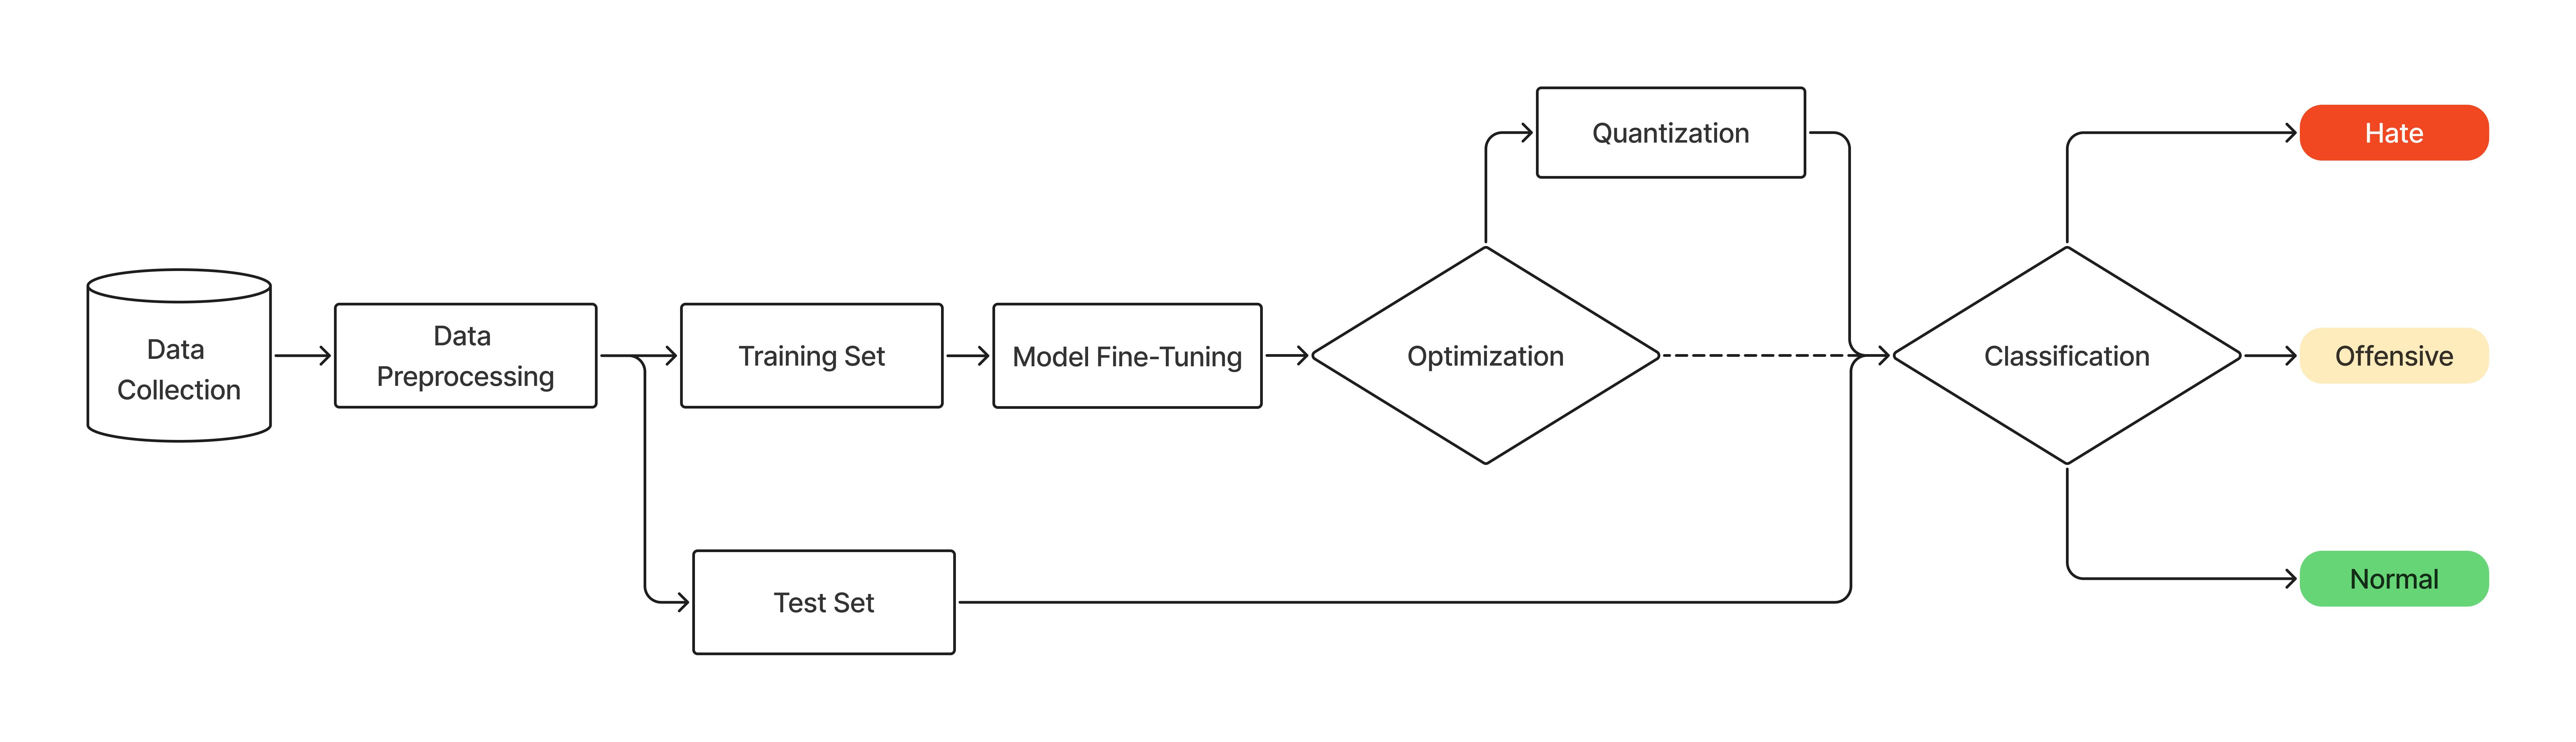

**Data Collection:** The initial step involves collecting and combining the hate speech Twitter (X) data from the measuring [hate speech dataset](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech) and the Automated Hate Speech Detection and the Problem of Offensive Language study by [Thomas Davidson et al](https://doi.org/10.48550/arXiv.1703.04009). ([GitHub Link](https://github.com/t-davidson/hate-speech-and-offensive-language).)

**Data Preprocessing:** The dataset is cleaned and preprocessed, removing unnecessary columns, rows, and text features (such as usernames, URLs, symbols, etc.) that constitute noise. Afterwards, Exploratory Data Analysis (EDA) is performed to obtain more information about the combined dataset.

**Dataset Split:** The dataset is split into 6000 training and 900 test samples, and the entries are formatted as prompts for the LLM. The test data is stored for future use during inference.

**Model Fine-Tuning:** The Llama 3.1 model is fine-tuned on the training data using [LoRA](https://doi.org/10.48550/arXiv.2106.09685) and [QLoRA](https://doi.org/10.48550/arXiv.2305.14314) and saved. Afterwards, the model can be used as is, or further optimized with quantization.

**Quantization:** The model is quantized using the [GPTQ algorithm](https://huggingface.co/docs/transformers/en/quantization/gptq#gptqmodel) and saved for inference.
Classification: After optimization, the model is used as a classifier for the dataset and sorts the test set into hate speech, offensive language or neutral classes. Afterwards, the output is evaluated based on the F1, precision, recall, and accuracy scores.


## Outline



* Light Data Preprocessing
* Fine-tuning
 * Prompt Setup
 * Evaluation Metric Setup: Classification Report and Confusion Matrix
 * Model Initialization and Quantization Setup
 * LoRA Configuration for Fine-Tuning
 * Training Arguments
 * Model Training and Saving
 * Loading Fine-Tuned Model
 * Merging and Saving the Model
* Testing
* Post-Training Quantization

In [ ]:
pip install torch tensorboard transformers datasets accelerate bitsandbytes peft trl gptqmodel --no-build-isolation optimum

In [ ]:
# Importing the necessary libraries
import pandas as pd
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTConfig, SFTTrainer, setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging,
                          GPTQConfig,
                          )
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from peft import AutoPeftModelForCausalLM, PeftModel

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

In [ ]:
df = pd.read_csv("hatespeech_combined.csv")
df.head()

## Fine-tuning

<img src="https://substack-post-media.s3.amazonaws.com/public/images/860734a2-4c33-472e-bc49-2099e8a97376_1634x1252.png" width="700">

For Fine-Tuning we'll be using a parameter-efficient finetuning (PEFT) method called **QLoRA (Quantized Low-Rank Adaptation)**

Unlike full-finetuning where the entire set of pre-trained weights of a model is updated during training. LoRA, low-rank matrix approximations are used to reduce the number of trainable parameters during fine-tuning [[1](https://arxiv.org/abs/2106.09685)].

### Prompt Setup

The code in the next cell performs the following:

* Initializes empty lists for the train and test sets to store data samples for each sentiment class.

* Splits the input dataset into training and test sets, with 2000 samples for training and 300 samples for testing, while ensuring equal representation of the three sentiment classes: "offensive", "hate", and "normal". The split is reproducible using a fixed random state.

* Combines the split data from each sentiment class into a single training and testing dataframe, shuffling the training set in a replicable order (random_state=10).

* Identifies residual examples that are not part of the training or test sets and groups them as our evaluation set. There is a sample of 300 instances of each sentiment for uniformity.

In [ ]:
# Creating empty lists for the train and test sets
X_train = []
X_test = []

# Splitting the training and test sets to have equal representations of each
# sentiment class
for sentiment in ["offensive", "hate", "normal"]:
    train, test  = train_test_split(df[df.sentiment==sentiment],
                                    train_size=2000,
                                    test_size=300,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

# Combining all the separate sentiments (offensive, hate, normal) into one df
X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

# Compiling a list of indices not used in training or test sets
eval_idx = []
for idx in df.index:
    if idx not in list(X_train.index) + list(X_test.index):
        eval_idx.append(idx)
# eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]

# Using previous list to compile tweets not included in the training & test sets
X_eval = df[df.index.isin(eval_idx)]

# Creating a balanced evaluation set by sampling 300 tweets from each sentiment group
# Group_keys = False, so group labels are not included in the output as a new column
X_eval = (X_eval.groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=300, random_state=10, replace=False)))

# Resetting index for training set
X_train = X_train.reset_index(drop=True)
print(f'X_train = {X_train}')

# Test set isn't reset for easy cross-checking later

We define two prompt generation functions for use with the Llama model:

* generate_prompt(data_point): Which creates a training prompt including the expected sentiment label.

* generate_test_prompt(data_point): Creates a testing prompt without the sentiment label, intended for inference.

In [ ]:
import textwrap

# Function to generate a training prompt
def generate_prompt(data_point):
    """
    Generates a training prompt for sentiment classification.

    Parameters:
        data_point (dict or pd.Series): A dictionary-like object containing
                                        - "cleaned_text": the text to classify
                                        - "sentiment": the actual sentiment label (offensive, hate, normal)

    Returns:
        str: A formatted prompt for training the model.
    """
    # Constructs a prompt string with the text and the expected sentiment label
    return textwrap.dedent(f"""
            Examine the text enclosed in the square brackets,
            determine if its sentiment is offensive, hate speech or normal and return the answer as
            the corresponding sentiment label "offensive", "hate", or "normal".

            [{data_point["cleaned_text"]}] = {data_point["sentiment"]}
            """).strip() # to remove any unwanted newline characters and spaces that might be included
                        # due to the multi-line string literals ("""..."""), e.g. "   Hello, World!   "

def generate_test_prompt(data_point):
    """
    This function generates a testing prompt for sentiment classification.

    Parameters:
        data_point (dict or pd.Series): A dictionary-like object containing
                                        - "cleaned_text": the text to classify

    Returns:
        str: A formatted prompt for model inference (without the sentiment label).
    """
    # Constructs a prompt string with the text but leaves the sentiment label blank this time
    return textwrap.dedent(f"""
            Examine the text enclosed in the square brackets,
            determine if its sentiment is offensive, hate speech or normal and return the answer as
            the corresponding sentiment label "offensive", "hate", or "normal".

            [{data_point["cleaned_text"]}] = """).strip()

In [ ]:
# Applying the generate_prompt function to each row of X_train and X_eval
# storing the results in a new dataframe

# To display whole rows
pd.set_option('display.max_colwidth', None)

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["cleaned_text"])
print(X_train.head())

X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["cleaned_text"])
print(X_eval.head())

# Storing the target labels for the test set
y_true = X_test.sentiment

# Applying the generate_prompt function to the test set
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1),
                      columns=["cleaned_text"])
print(X_test.head())

# Converting the training and evaluation dfs into datasets for model training
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

### Evaluation Metric Setup: Classification Report and Confusion Matrix

In [ ]:
# Function to create the classification report and confusion matrix
def evaluate(y_true, y_pred):
    """
    Evaluates the model's performance by calculating accuracy, generating a classification report,
    and plotting a confusion matrix.

    Parameters:
        y_true (list or array-like): The true sentiment labels.
        y_pred (list or array-like): The predicted sentiment labels from the model.

    Returns:
        None: Prints the accuracy, classification report, and displays the confusion matrix.
    """
    mapping = {'offensive': 1, 'normal':2, 'hate': 0} # Since cm is expecting num. values &
                                                      # for .get method

    # Function to map the sentiment labels to their respective integer values
    def map(x):
        return mapping.get(x, 2) # if not hate speech, or offensive, equate to 2
                                 # Could use if-else statements too:
                                 # if x == "offensive": return 1...

    # Vectorizing the map function and applying it to both y_true and y_pred
    vectorized_map = np.vectorize(map)
    y_true = vectorized_map(y_true) # y_true = [map(x) for x in y_true]
    y_pred = vectorized_map(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Displaying answer as a matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Hate Speech", "Offensive", "Normal"])
    cm_display.plot()

### Model Initialization and Quantization Setup

We load the model in NormalFloat 4 (NF4) quantization and fine-tune with QLoRA

In the cell below, we:

* loaded the Llama 3.1 model from the Hugging Face model hub, configuring the compute data type to 16-bit floating point (float16) to balance computation precision [[2](https://mlabonne.github.io/blog/posts/Introduction_to_Weight_Quantization.html)].

* Quantize the model weights to 4-bit precision (NF4) (recommended by [QLoRA paper](https://arxiv.org/abs/2305.14314)) using the BitsAndBytes library. We also use double-quantization as recommended by the paper since it further reduces the average memory footprint .

* Load the pretrained model using AutoModelForCausalLM and the model_name [[3](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForCausalLM)].

* Set the model's cache usage to False to optimize training performance, as caching can cause issues during training but may be enabled later for faster inference.

* Load the tokenizer using AutoTokenizer with trust_remote_code=True, allowing the use of custom tokenizer code from the model repository.

* Set the padding token to the end-of-sequence (EOS) token. In causal language models (CLMs), the End-of-Sequence (EOS) token is often used to indicate the end of a text generation. However, they do not inherently use a padding token. Llama does not have a separate padding token, but is trained to recognize the EOS token as the end of input. Using the EOS token as padding makes the model ignore padded parts during generation.

* We also configure the padding side to right since CLMs generate text from left to right and right padding ensures that the meaningful tokens are on the left, and padding tokens are at the end of the sequence.

* Prepare the model and tokenizer for chat-based inputs and outputs by calling the setup_chat_format function, making them ready for conversational tasks.

In [ ]:
model_name = "meta-llama/Meta-Llama-3.1-8B-instruct" # from hf

# Setting compute data type to 16-bit fp to maintain a reasonable precision in computations
compute_dtype = getattr(torch, "float16")

# Quantizing model weights to 4-bit precision using 4-bit NormalFloat
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Loading the pretrained model for causal language modeling with the 4-bit quantization configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)

model.config.use_cache = False # Enable after training for faster inference
#model.config.pretraining_tp = 1 # If needed

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code=True, # Trusting remote code from model's source repository to load custom tokenizer code
                                         )
# Setting the tokenizer's padding token to the end-of-sequence token to reduce model complexity
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Preparing the model and tokenizer for chat-based inputs/outputs
tokenizer.chat_template = None
model, tokenizer = setup_chat_format(model, tokenizer)

https://huggingface.co/docs/transformers/en/main_classes/pipelines

In this step, we initialize a text generation pipeline using the specified model and tokenizer, configured with a maximum of 4 new tokens and a low temperature (0.01) to generate deterministic outputs.

We also iterate over the test set, generating predictions for each cleaned text input, extracting the sentiment label from the generated text, and classifying the sentiment as "hate", "offensive", or "normal" based on the presence of specific keywords. The predicted labels are stored in a list, which is returned after processing all inputs.

In [ ]:
# Function to predict the sentiment labels
def predict(model, tokenizer):
    """
    Predicts sentiment labels for a given test set using a text generation model.

    Parameters:
        model (transformers.PreTrainedModel): The pre-trained language model to generate predictions.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer compatible with the model.

    Returns:
        list: A list of predicted sentiment labels (e.g., 'hate', 'offensive', 'normal').
    """
    y_pred = []                # Empty list to store predicted sentiment labels
    generated_texts = []       # List to store all generated text from the model for each input

# Setting up text-generation pipeline
    pipe = pipeline(task="text-generation",
                    model=model,
                    tokenizer=tokenizer,
                    max_new_tokens=4,         # Limits the number of tokens generated
                    temperature=0.01,         # For more deterministic output
                   )

    # Iterating over each row in the test set
    for i in tqdm(range(len(X_test))):                  # tqdm for progress bar
        prompt = X_test.iloc[i]["cleaned_text"]         # Extracting the cleaned text from the test set as the prompt

        result = pipe(prompt)                           # Generate text from the model based on the input prompt. Sample: [{'generated_text': "I can't believe you did...}]
        generated_text = result[0]['generated_text']    # Extract the generated text from the result. Generated_text is a dict key
        generated_texts.append(generated_text)          # Append the generated text to list with all generated texts

        # Extract the part of the generated text containing sentiment label
        answer = result[0]['generated_text'].split("=")[-1]   # Get the part of the generated text containing the sentiment label

        # Classifying the sentiment based on keywords in the extracted text
        if "hate" in answer:
            y_pred.append("hate")
        elif "offensive" in answer:
            y_pred.append("offensive")
        else:
            y_pred.append("normal")

    print(generated_texts)        # Print the list of generated texts
    return y_pred                 # Returns list of predicted sentiment labels

In [ ]:
y_pred = predict(model, tokenizer)

In [ ]:
 evaluate(y_true, y_pred)

As seen from the confusion matrix, the base model classifies half of the posts correctly and will need further fine-tuning.

### LoRA Configuration for Fine-Tuning

Mathematically, full fine-tuning is done with a weight update matrix $ΔW$, which is added to the original weight matrix $W$. This results in the new weight matrix, $W^1 = W + ΔW$, where $W^1$ is the updated weight. While this technique adapts the model fully to a new task, it involves updating millions & billions of parameters, making it a computationally expensive option.

With **LoRA** however, instead of updating the entire pre-trained model, the original weight matrix, $W$ (the pre-trained weights) is frozen and the weight update, $ΔW$ is decomposed into the product of 2 smaller rank matrices, $W_A$ & $W_B$, and trained [[3](https://doi.org/10.48550/arXiv.2106.09685)]. After training, these two smaller matrices are added to the original weight matrix, giving $W^1 = W + W_A W_B$ [[4](https://sebastianraschka.com/blog/2023/llm-finetuning-lora.html)].

Another important component of LoRA is the presence of adapter modules [[5](https://doi.org/10.48550/arXiv.2110.07280)] into specific layers (like the attention layer) of the model, without directly modifying the original parameters. These adapters are lightweight modules that implement the low-rank matrix decomposition of the weight updates. Specifically, the adapters learn two smaller matrices, $W_A$ and $W_B$ in our case, whose products approximate the weight update $ΔW$. These adapters are trained during fine-tuning and contain fewer trainable parameters, compared to full model fine-tuning. Since LoRA uses low-rank decomposition to approximate the updates, task adaptation is achieved with minimal memory usage and faster training times, but could lead to some information loss.

**QLoRA** (Quantized LoRA) is LoRA with a key difference: before inserting the adapters and fine-tuning, the original model weights are quantized/compressed from full precision (float32) or half-precision (float16) down to 4-bit precision, specifically NormalFloat 4 (NF4) quantization [65](https://doi.org/10.48550/arXiv.2305.14314)]. As in LoRA, the model weights are then frozen and only the small low-rank adapter matrices ($W_A$ and $W_B$) are trained. With QLoRA, the 4-bit quantized weights are dequantized/decompressed to float16 precision for computations during fine-tuning allowing for more efficient matrix operations on GPUs.


The parameters below were chosen based on the LoRA paper [[3](https://doi.org/10.48550/arXiv.2106.09685)].

* lora_alpha: Alpha scaling factor of 16 to balance adaptation strength and maintain model stability.

* lora_dropout: The dropout probability for the LoRA update matrices.

* r: Rank of 64 for the LoRA matrices to capture model updates efficiently without significantly increasing the number of trainable parameters.

* bias: No additional bias was chosen to minimize parameter count while focusing on core weight updates.

* target_modules: Targets all linear layers except the output layer to enhance model adaptability while preserving the core structure, specifically for causal language modeling where predicting the next word is essential.

* task_type: Specifies the type of task the model is being fine-tuned for.


In [ ]:
output_dir="trained_weights"

# LoRA
peft_config = LoraConfig(
        lora_alpha=16,               # Scaling factor for the LoRA layers, controls the strength of adaptation
        lora_dropout=0.1,            # Dropout probability to prevent overfitting during fine-tuning
        r=64,                        # Rank of the LoRA matrices
        bias="none",                 # Can be 'none', 'all' or 'lora_only'. 'none' reduces number of trainable parameters
        target_modules="all-linear", # Applies LoRA to all linear layers of the model excluding the output layer
        task_type="CAUSAL_LM",       # Causal Language Modeling
)

### Training Arguments

Setting SFTConfig parameters [[7](https://huggingface.co/docs/trl/en/sft_trainer)]

In [ ]:
sft_config = SFTConfig(
    output_dir=output_dir,                    # Directory to save the trained model and logs
    num_train_epochs=1,                       # Number of epochs for training
    per_device_train_batch_size=1,            # The batch size for each device
    gradient_accumulation_steps=8,            # Accumulates gradients for n steps before updating weights
    gradient_checkpointing=True,              # Reduces memory consumption by saving intermediate activations
    optim="paged_adamw_32bit",                # The optimizer used
    save_steps=0,                             # No intermediate saving of model checkpoints during training
    logging_steps=25,                         # Log metrics every 25 steps
    learning_rate=5e-4,
    weight_decay=0.001,                       # A small weight decay to prevent overfitting
    fp16=True,                                # Mixed precision training with FP16 to reduce memory usage
    max_grad_norm=0.3,                        # Clipping gradient norm to avoid exploding gradients, based on QLoRA paper
    max_steps=-1,                             # Setting to -1 means there is no early stopping based on number of steps
    warmup_ratio=0.03,                        # Warmup period for learning rate scheduler, 3% of total steps
    group_by_length=True,                     # Groups samples by length to minimize padding, i.e. efficient batching
    lr_scheduler_type="cosine",               # Cosine learning rate scheduler that gradually reduces learning rate
    report_to="tensorboard",                  # Logs training metrics to TensorBoard for visualization
    eval_strategy="epoch",                    # Evaluates and saves a checkpoint at the end of each epoch
    max_seq_length=1024,                      # The maximum number of tokens that can be input to the model at once.
    dataset_text_field="cleaned_text",
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_data,                 # Training dataset
    eval_dataset=eval_data,                   # Evaluation dataset
    peft_config=peft_config,                  # LoRA configuration
)

### Model Training and Saving

In [ ]:
%load_ext tensorboard
%tensorboard --logdir trained_weights/runs

In [ ]:
# Train model
trainer.train()

In [ ]:
# Save trained model and tokenizer
trainer.save_model()                    # Save the model weights to the output directory
tokenizer.save_pretrained(output_dir)   # Save the tokenizer configurations

In [ ]:
# Run for immediate inference without merging adapters
OUTPUT_DIR = "/content/trained_weights"
finetuned_model = PeftModel.from_pretrained(model, OUTPUT_DIR)
y_pred = predict(finetuned_model, tokenizer)

In [ ]:
evaluate(y_true, y_pred)

In [ ]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config]
del [df, X_train, X_eval]
del [SFTConfig, sft_config, SFTTrainer, LoraConfig]

In [ ]:
# To clear cache
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

### Loading Fine-Tuned Model

In [ ]:
finetuned_model = "/content/trained_weights"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Note: Can load_in_8bit or load_in_4bit to reduce memory consumption at the cost of accuracy
model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,           # Use float16 for model weights
     return_dict=False,                   # To not return the output as a dictionary
     low_cpu_mem_usage=True,              # Reduce CPU memory usage during loading
     device_map="auto",                   # Map model weights to the specified device
)

### Merging and Saving the Model

In [ ]:
merged_model = model.merge_and_unload() # Merging the model parameters and unload unnecessary components
merged_model.save_pretrained("./merged_model",safe_serialization=True, max_shard_size="10GB") # Saving the merged model with safe serialization and sharding options
tokenizer.save_pretrained("./merged_model") # Saving the tokenizer alongside the merged model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

## Testing

We load the merged model as we loaded the base version

In [ ]:
model_name = "/content/drive/MyDrive/merged_model"

# Setting compute data type to 16-bit fp to maintain a reasonable precision in computations
compute_dtype = getattr(torch, "float16")

# Quantizing model weights to 4-bit precision using 4-bit NormalFloat
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Loading the pretrained model for causal language modeling with the 4-bit quantization configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
    return_dict=True,
)

model.config.use_cache = True # Enabled after training for faster inference

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code=True, # Trusting remote code from model's source repository to load custom tokenizer code
                                         )
# Setting the tokenizer's padding token to the end-of-sequence token to reduce model complexity
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Preparing the model and tokenizer for chat-based inputs/outputs
tokenizer.chat_template = None
model, tokenizer = setup_chat_format(model, tokenizer)

In [ ]:
y_pred = predict(model, tokenizer)

In [ ]:
evaluate(y_true, y_pred)

In [ ]:
# Copying to google drive
import shutil

# Define source and destination paths
source_dir ='./merged_model'
destination_dir = '/content/drive/MyDrive/merged_model'

# Copy the entire directory
shutil.copytree(source_dir, destination_dir)

## Post-Training Quantization

Quantization allows for the compression of large models for efficient deployment. The floating-point representations of the LLM parameters (weights) and activations (hidden layer outputs) are typically 32-bit (FP32) or 16-bit (FP16). During quantization, these weights are lowered to lower-precision integer formats like INT8 or INT4, thereby reducing computation overhead while maintaining accuracy.

Empirical analyses show that INT8 quantization generally preserves model performance. However, INT4 quantization would require more advanced quantization techniques to minimize model degradation. Furthermore, it is noted by [[8](https://doi.org/10.48550/arXiv.2303.18223)] that LLMs are less sensitive to quantization than smaller ones, suggesting that a lower-precision 70 billion-parameter model may outperform a higher-precision 7 billion-parameter model with comparable memory requirements.

We use post-training quantization (PTQ) here as an approach for compressing (pre-)trained models after finetuning, reducing the computational resources, model size, and latency during model inference while maintaining accuracy. This makes PTQ an invaluable technique for LLM deployment [[9](https://doi.org/10.48550/arXiv.2212.07048)].

For PTQ, we use the GPTQ library from hugging face [[10](https://huggingface.co/docs/transformers/en/quantization/gptq#gptqmodel)] implementing the GPTQ algorithm [[11](https://arxiv.org/abs/2210.17323)].

In [ ]:
# Quantizing fine-tuned model with GPTQ
model_id = "/content/drive/MyDrive/may16_merged_model_3.1"
tokenizer = AutoTokenizer.from_pretrained(model_id)
gptq_config = GPTQConfig(bits=4, dataset="c4", tokenizer=tokenizer) # Using C4 dataset as calibration data to simulate real input distributions.

# Load the fine-tuned model and apply post-training quantization using GPTQ
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",                          # Ensures outputs are returned as a dictionary for easier access
    return_dict = "True",
    quantization_config=gptq_config,
)

In [ ]:
'''# For Inference only

model_name_or_path = "/content/drive/MyDrive/quant_model2"
model_basename = "model"
quantization_config_loading = GPTQConfig(bits=4, exllama_config={"version":2})
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# loading quantized model to the GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cuda",
    return_dict = "True",
    quantization_config=quantization_config_loading,
)'''

In [ ]:
y_pred = predict(model, tokenizer)

In [ ]:
evaluate(y_true, y_pred)

In [ ]:
# Saving the quantized model
model.save_pretrained("quant_model", safe_serialization=True, max_shard_size="10GB")
tokenizer.save_pretrained("quant_model")

In [ ]:
# Copying to google drive
import shutil

# Define source and destination paths
source_dir ='/content/quant_model'
destination_dir = '/content/drive/MyDrive/quant_model2'

# Copy the entire directory
shutil.copytree(source_dir, destination_dir)

In [ ]:
# Creating a df for the evaluation results
evaluation = pd.DataFrame({
    'text': X_test["text"],  # Original text from the test set
    'y_true': y_true,        # True labels from the test set
    'y_pred': y_pred         # Predicted labels from the fine-tuned LLM
})

# Save the evaluation DataFrame to a CSV file
evaluation.to_csv("test_predictions.csv", index=False)  # Save without including the index column